<a href="https://colab.research.google.com/github/likeshd/time_series_models_libraries/blob/main/metro_traffic_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree

import datetime
from datetime import date
import random


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import Data
data = pd.read_csv('/content/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [4]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [6]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [7]:
data = data.set_index(pd.DatetimeIndex(data['date_time'])).rename(columns={"date_time": "ds"}).drop_duplicates(subset=['ds'])

In [8]:
ts = data['2018-06-30':'2018-09-29']
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2018-06-30 00:00:00,NaN,302.87,0.0,0.0,1,Clear,sky is clear,2018-06-30 00:00:00,1423
2018-06-30 01:00:00,NaN,302.58,0.0,0.0,1,Clear,sky is clear,2018-06-30 01:00:00,869
2018-06-30 02:00:00,NaN,302.55,0.0,0.0,1,Thunderstorm,proximity thunderstorm,2018-06-30 02:00:00,617
2018-06-30 03:00:00,NaN,302.29,0.0,0.0,40,Rain,moderate rain,2018-06-30 03:00:00,429
2018-06-30 04:00:00,NaN,301.29,0.0,0.0,1,Rain,light rain,2018-06-30 04:00:00,429


In [9]:
split_date = '2018-09-22'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

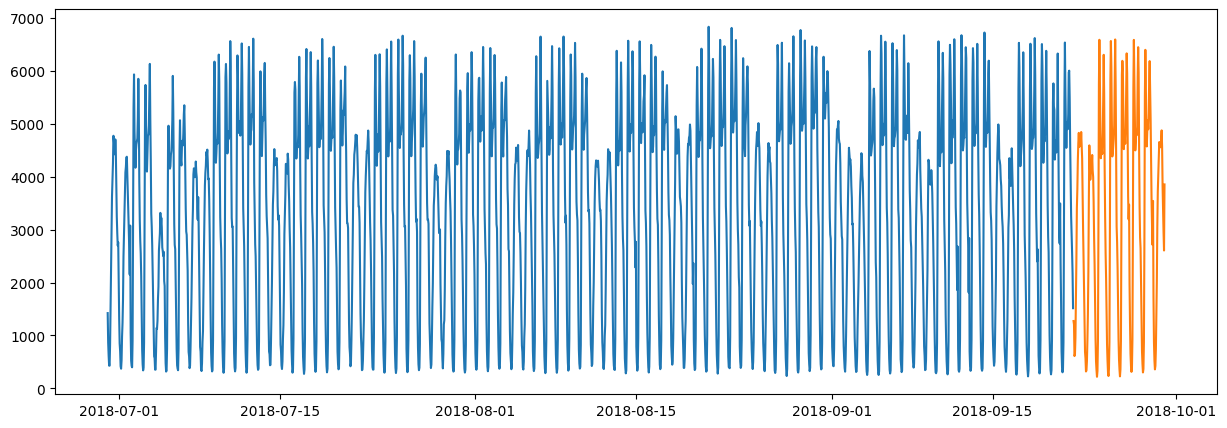

In [10]:
plt.figure(figsize=(15,5))
plt.plot(ts_train.traffic_volume)
plt.plot(ts_test.traffic_volume)
plt.show()

### Create Time Series Features

In [15]:
def create_features(df, label=None, all_features=False):
    """
    Creates time series features from datetime
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day


    if all_features:
        X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth',
                'holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description']]
    else :
        X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [16]:
X_train, y_train = create_features(ts_train, label='traffic_volume', all_features=False)
X_test, y_test = create_features(ts_test, label='traffic_volume', all_features=False)

### Create XGboost model with only time features

In [17]:
%%time
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train)

CPU times: user 2.64 s, sys: 63.3 ms, total: 2.7 s
Wall time: 2.23 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

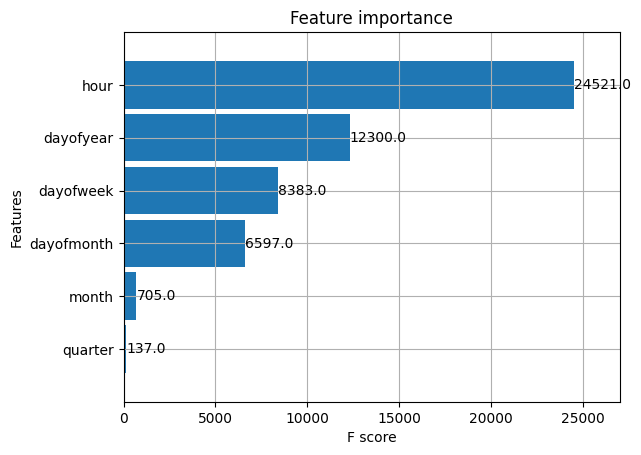

In [18]:
plot_importance(reg, height=0.9)

In [19]:
# Predict on test data
%%time
y_pred = reg.predict(X_test)

CPU times: user 36.2 ms, sys: 968 µs, total: 37.1 ms
Wall time: 45.1 ms


In [20]:
# Error Metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
def error_metrics(y_true, y_pred):
    print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print('Mean Absolute percentage Error: {:.2f} %'.format(mean_absolute_percentage_error(y_true, y_pred)))

In [22]:
#Calculate Model error
error_metrics(ts_test.traffic_volume, y_pred)

Mean Absolute Error: 240.54
Root Mean Squared Error: 321.41
Mean Absolute percentage Error: 18.36 %


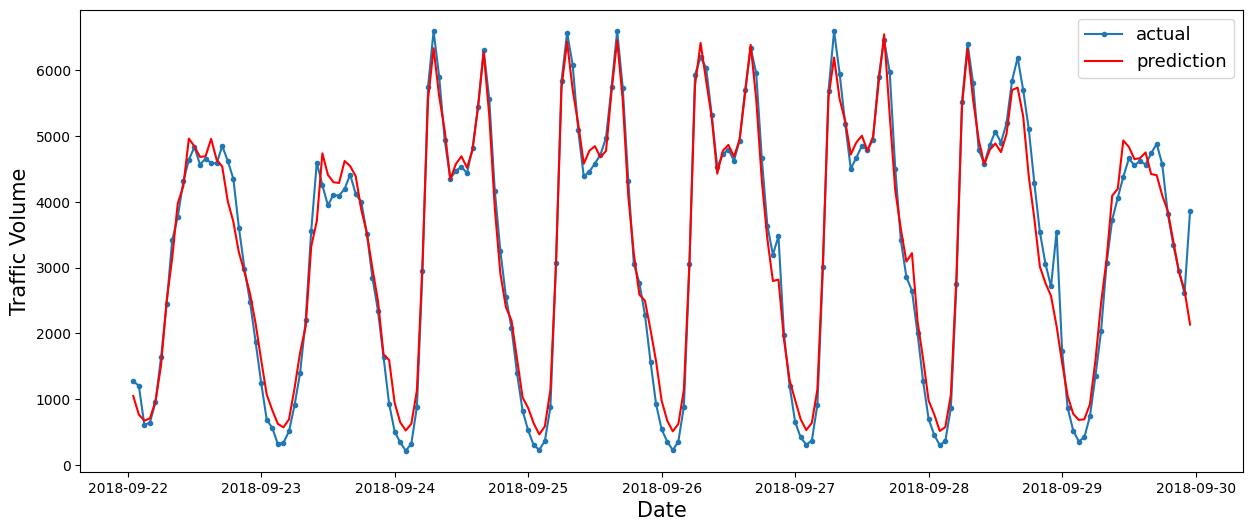

In [23]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

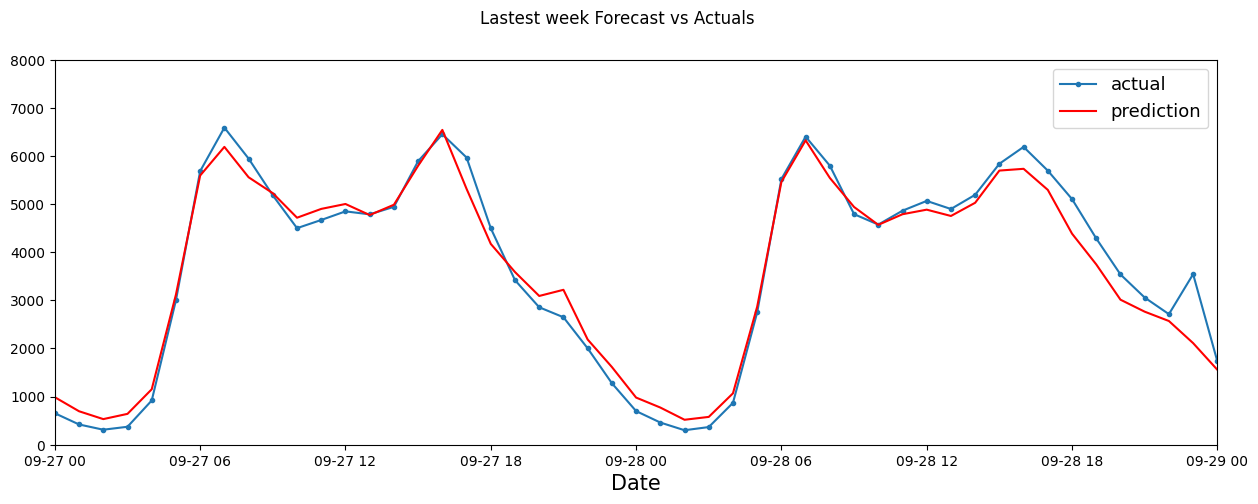

In [24]:
# zoom on lastest 2 days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

### Create XGboost model with all features

In [25]:
X_train, y_train = create_features(ts_train, label='traffic_volume', all_features=True)
X_test, y_test = create_features(ts_test, label='traffic_volume', all_features=True)

In [26]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [27]:
# Feature engineering
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, make_column_selector(dtype_include="object")),
        ("num", numeric_transformer, make_column_selector(dtype_exclude="object")),
    ]
)

In [28]:
my_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

In [29]:
# Transform the data
X_train = my_pipeline.fit_transform(X_train)
X_test = my_pipeline.transform(X_test)

In [30]:
%%time
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train)

CPU times: user 2.06 s, sys: 32 ms, total: 2.09 s
Wall time: 1.15 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Predict on test data

In [ ]:
%%time
y_pred = reg.predict(X_test)

##### Error Metrics

In [31]:
#Calculate Model error
error_metrics(ts_test.traffic_volume, y_pred)

Mean Absolute Error: 240.54
Root Mean Squared Error: 321.41
Mean Absolute percentage Error: 18.36 %


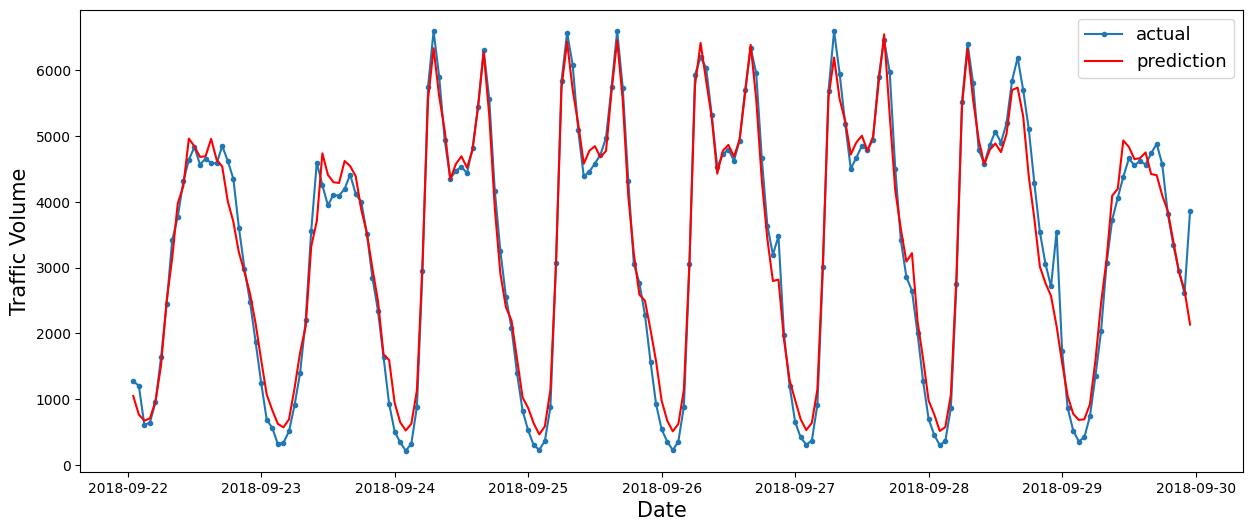

In [32]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

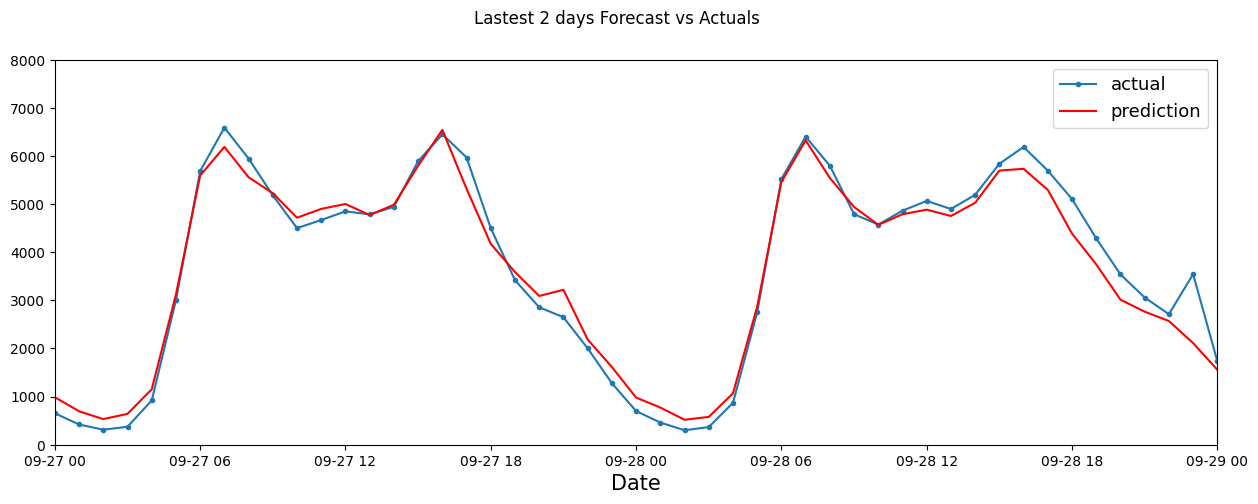

In [33]:
# zoom on lastest 2 days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest 2 days Forecast vs Actuals')

## HyperParmeter Tuning

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [35]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [36]:
# Initialize space or a required range of values
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'subsample' : hp.quniform('subsample', 0.6, 1, 0.05),
        'n_estimators': hp.uniform('n_estimators', 500, 1000)
    }

In [37]:
# Define objective function
def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                           reg_alpha = int(space['reg_alpha']) ,reg_lambda=space['reg_lambda'],
                            colsample_bytree=space['colsample_bytree'], min_child_weight=space['min_child_weight']
                           ,subsample=space['subsample'])
    kfold = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = 'neg_mean_absolute_percentage_error')
    score = results.mean() * (-100)
    print ("SCORE:", score)
    return {'loss':score, 'status': STATUS_OK, 'model': model}

In [38]:
trials = Trials()

In [39]:
%%time
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

SCORE:
9.275472619273732
SCORE:
10.05417582650356
SCORE:
19.74219058850559
SCORE:
21.280615054421663
SCORE:
31.581870733461603
SCORE:
17.98122056653793
SCORE:
14.8656077519082
SCORE:
11.507706379598877
SCORE:
21.515323514256544
SCORE:
23.334429456953995
SCORE:
20.6159861633791
SCORE:
14.444931919549123
SCORE:
9.806500215099657
SCORE:
18.650184222632753
SCORE:
8.773172143880394
SCORE:
18.468025255777164
SCORE:
36.70916190548181
SCORE:
14.628487611192003
SCORE:
28.31656246835249
SCORE:
9.056919762932873
SCORE:
10.857648899836772
SCORE:
9.434295064191337
SCORE:
8.744525862458067
SCORE:
13.74188224584763
SCORE:
8.670841481622833
SCORE:
9.215103412613903
SCORE:
16.06478902221969
SCORE:
11.40160723468516
SCORE:
8.199815382984998
SCORE:
9.008041277517334
SCORE:
8.374781985592763
SCORE:
7.935227944065172
SCORE:
8.171238477176225
SCORE:
20.51276482328399
SCORE:
6.523151054688898
SCORE:
8.577681906867044
SCORE:
6.5584392400260425
SCORE:
25.347388052968334
SCORE:
10.486479640486666
SCORE:
22.5646

In [40]:
print (best)

{'colsample_bytree': 0.9859421576082227, 'gamma': 7.079176870957298, 'max_depth': 12.0, 'min_child_weight': 3.0, 'n_estimators': 996.0597329846684, 'reg_alpha': 0.6699298503073832, 'reg_lambda': 0.8300730520054822, 'subsample': 1.0}


In [41]:
best['max_depth'] = int(best['max_depth'])
best['n_estimators'] = int(best['n_estimators'])

In [43]:
reg_opt = xgb.XGBRegressor(**best)

In [44]:
%%time
reg_opt.fit(X_train, y_train)

CPU times: user 1.86 s, sys: 20.1 ms, total: 1.88 s
Wall time: 1.51 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9859421576082227, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=7.079176870957298,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=3.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=996, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Predict on test data

In [45]:
%%time
y_pred = reg_opt.predict(X_test)

CPU times: user 20.3 ms, sys: 7 µs, total: 20.3 ms
Wall time: 22.8 ms


In [46]:
# Error Metrics
#Calculate Model error
error_metrics(ts_test.traffic_volume, y_pred)

Mean Absolute Error: 208.28
Root Mean Squared Error: 305.62
Mean Absolute percentage Error: 11.04 %


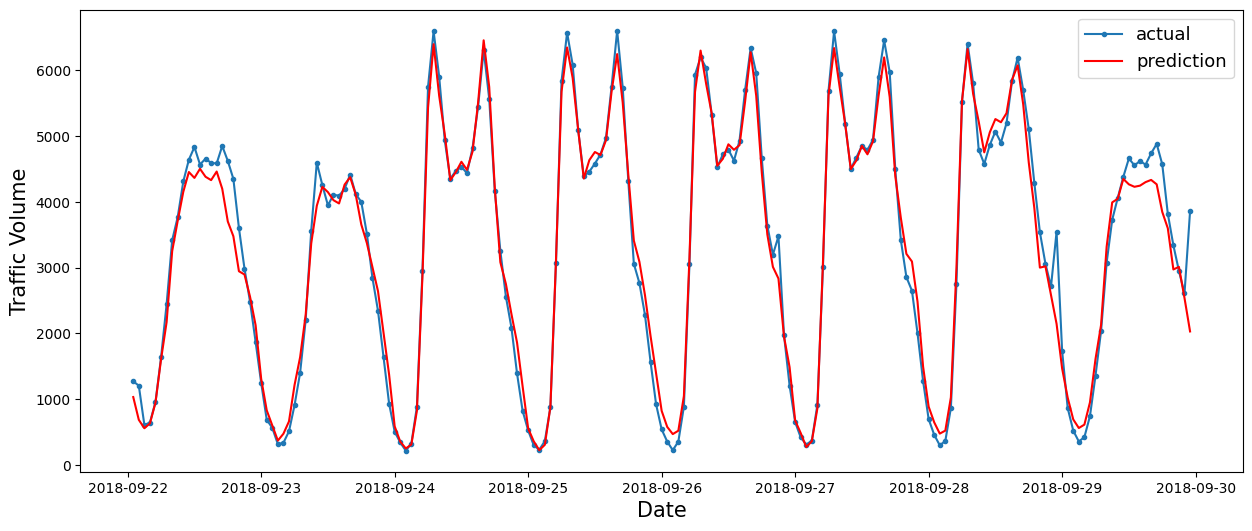

In [47]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

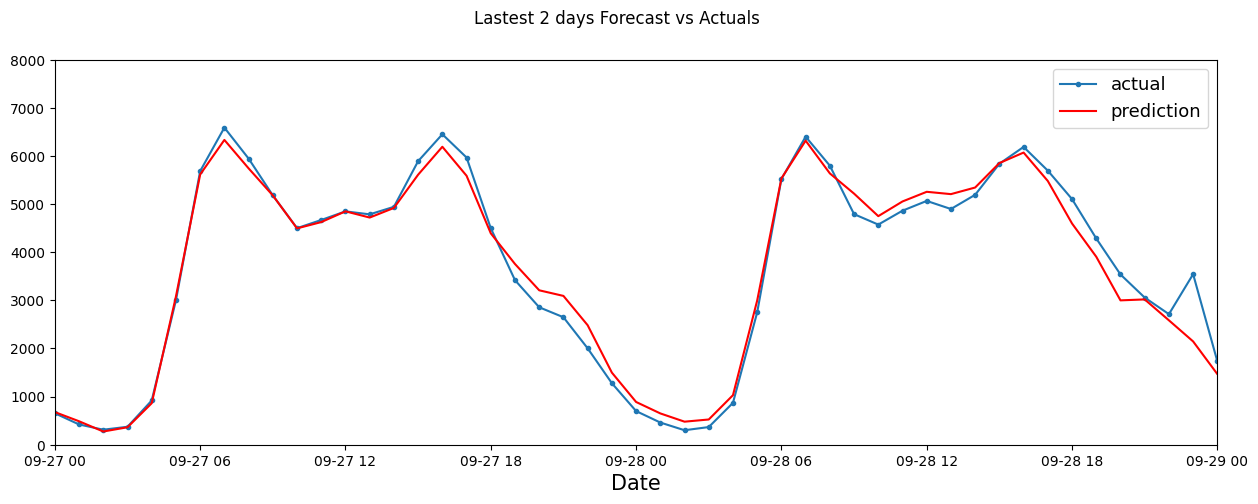

In [48]:
# zoom on lastest 2 days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest 2 days Forecast vs Actuals')